## Computing lensing C_ell(ell) for reasonable redshift distribution of sources and parameter values


To get started with computing and also understanding the C_ells: once you have CCL installed, try to use it to compute and plot lensing C_ell as a function of ell for any reasonable redshift distribution of sources and any reasonable parameter values (combining equation 16 and equation 5 in the first paper above by Krause et al.). Use CCL to get the basic building blocks of this like the matter power spectrum and comoving distances, but don't just use the functionality to directly get the C_ells, do the integration numerically yourself using numpy / scipy. You should however use the built in CCL functionality to check you're getting it right and debug. You can find examples for using CCL that will help here: https://github.com/LSSTDESC/CCLX (you can also steal a redshift distribution to use from where they construct one in those examples notebooks).

Eq 1: $C^{ij}_{\mathcal{A}\mathcal{B}}(\ell) = \int d\chi \frac{W^{i}_{\mathcal{A}}(\chi)W^{j}_{\mathcal{B}}(\chi) }{\chi^2}P_{\mathcal{A}\mathcal{B}} ( k = \frac{\ell + 0.5}{\chi}, z) $

Where:
- i,j denote redshift bins
- Subscripts $\mathcal{A}\mathcal{B} \in \{\delta_g, \kappa\}$ stand for specific E- and B- modes (kappa) or for specific observed galaxy number densities (delta)
- C is the angular power spectrum
- $P_{\delta}$ is three-dimensional matter power spectrum
- $\chi$ is comoving distance

Eq 4: $W^{i}_{\kappa,g}(\chi) = \frac{3\Omega_{m}H_{0}^{2}}{2c^2} \int_{\chi}^{\infty}d\chi'n^{i}_{g}(\chi')\frac{\chi}{a(\chi)}\frac{\chi' - \chi}{\chi'}$

Where W is the tomographic lens efficiency

In [1]:
#bits of the code come from CCLX/Example MCMC analysis on GitHub

import emcee
import matplotlib.pyplot as plt 
import pyccl as ccl
import numpy as np
import scipy
#import manual_C_ell_def as manualCell

# for nicer plots http://seaborn.pydata.org -- optional
# if you don't want to use it, you can comment this and the next line

import seaborn as sns; sns.set_style('darkgrid')
sns.set_context("talk")
%matplotlib inline

In [2]:

# define the reasonable redshift distribution from github
def redshiftdist(z):
    
    i_lim = 26.                                                            # Limiting i-band magnitude
    z0 = 0.0417 * i_lim - 0.744
    pz = 1. / (2. * z0) * (z / z0)**2. * np.exp(-z / z0)                   # Redshift distribution, p(z)
    
    return pz                                                              # to check for normalized pz print(scipy.integrate.simps(pz, z))

# solves equation 4
# note: z here is an array not a single value. returns array

def Wkappag(z, c, cosmo):
    
    zmax = 6.                                                              # z at horizon from Planck 2018
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)                           # units of Mpc
    
    Wkg = np.zeros(len(z))     
    for i in range(len(z)):                                                # TODO is this a reasonable way of calculating this stuff?
        x = np.linspace(z[i],zmax,int(1e4))                                # variable we integrate over
        ax = 1/(1 + x)
        chix = ccl.comoving_radial_distance(cosmo,ax)
        dchidx = c/(cosmo['H0']*ccl.h_over_h0(cosmo,ax))
        px = redshiftdist(x)
        integrand = px*chiz[i]*(chix - chiz[i])/(a[i]*chix)
        Wkg[i] = scipy.integrate.simps(integrand, x)*3*cosmo['Omega_m']*(cosmo['H0']**2)/(2*c**2)
    Wkg[len(z)-1] = 0.0                                                    # The last integral is over nothing. to avoid nan
    
    return Wkg

# function that finds C_ell(ell) for a given z distribution. A, B, i, j can be changed by manually changing quantities in the function
# Note: if we assume \LambdaCDM cosmology (or some cosmology) don't need function h_over_h0. 
# Can find chi(z) and z(chi) manually

def findC_ell(cosmo,c,ell,z):
                                                                          # find useful functs of z
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)
    Wkg = Wkappag(z, c, cosmo)                                            # find tomographic lens efficiency
                                                                          # find matter power spectrum
    MatterPowerSpec_lz = np.zeros((len(z),len(ell)))
    for i in range(len(z)):                                               # MatterPowerSpec_lz[i] is for ith z
        MatterPowerSpec_lz[i] = ccl.power.nonlin_power(cosmo, (ell + 0.5)/chiz[i] , a[i])
    MatterPowerSpec_lz = np.transpose(MatterPowerSpec_lz)
                                                                          # find C_ell
    C_ell = np.zeros(len(ell))
    for i in range(len(ell)):
        integrand = (Wkg**2)*MatterPowerSpec_lz[i]/(chiz**2)
        C_ell[i] = scipy.integrate.simps(integrand, chiz, axis = 0)
    return C_ell

def findC_ell_linear(cosmo,c,ell,z):
                                                                          # find useful functs of z
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)
    Wkg = Wkappag(z, c, cosmo)                                            # find tomographic lens efficiency
                                                                          # find matter power spectrum
    MatterPowerSpec_lz = np.zeros((len(z),len(ell)))
    for i in range(len(z)):                                               # MatterPowerSpec_lz[i] is for ith z
        MatterPowerSpec_lz[i] = ccl.power.linear_power(cosmo, (ell + 0.5)/chiz[i] , a[i])
    MatterPowerSpec_lz = np.transpose(MatterPowerSpec_lz)
                                                                          # find C_ell
    C_ell = np.zeros(len(ell))
    for i in range(len(ell)):
        integrand = (Wkg**2)*MatterPowerSpec_lz[i]/(chiz**2)
        C_ell[i] = scipy.integrate.simps(integrand, chiz, axis = 0)
    return C_ell

# Program starts here

In [3]:
# define cosmological parameters
cosmo = ccl.Cosmology(Omega_c=0.27, 
                      Omega_b=0.045, 
                      h=0.67, 
                      n_s=0.96,  
                      sigma8=0.83, 
                      transfer_function='bbks')

c = 3e5                                                                  # km/s

In [4]:
# define cosmological parameters for equivalent linear theory
cosmo1 = ccl.Cosmology(Omega_c=0.27, 
                      Omega_b=0.045, 
                      h=0.67, 
                      n_s=0.96,  
                      sigma8=0.83, 
                      transfer_function='bbks',
                      matter_power_spectrum='linear')


In [5]:
print(cosmo["H0"])

67.0


In [6]:
# create an angular shear C_ell manually with our functions above
# Note: define ell from github 
# np.seterr(divide='ignore', invalid='ignore') -- in integrals ignores bits when/0

ell = np.arange(2, 2000)
delta_ell = ell[1] - ell[0]
z = np.linspace(0.001, 4., int(1e4))                                     # z =/= 0 otherwise get inf when calculating chi

print(scipy.integrate.simps(redshiftdist(z), z))                         # To check whether p(z) is normalized

# calculate C_ell
manualdata = findC_ell(cosmo,c,ell,z)

0.9993590255745917


In [7]:
# calculate C_ell_linear

manualdata_linear = findC_ell_linear(cosmo1,c,ell,z)

In [8]:
#create an angular shear C_ell with pyccl (non-linear and linear)

i_lim = 26.                                                              # Limiting i-band magnitude
z0 = 0.0417 * i_lim - 0.744
Ngal = 46. * 100.31 * (i_lim - 25.)                                      # Normalisation, galaxies/arcmin^2
pz = 1. / (2. * z0) * (z / z0)**2. * np.exp(-z / z0)                     # Redshift distribution, p(z)
dNdz = Ngal * pz                                                         # Number density distribution
#why are they normalizing with Ngal? Tracer renormalizes to 1 anyways

tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz))
tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz))
data    = ccl.angular_cl(cosmo, tracer1, tracer2, ell)                   # C_ell - uses non-linear matter power spectrum stored in `cosmo`

data_linear = ccl.angular_cl(cosmo1, tracer1, tracer2, ell)

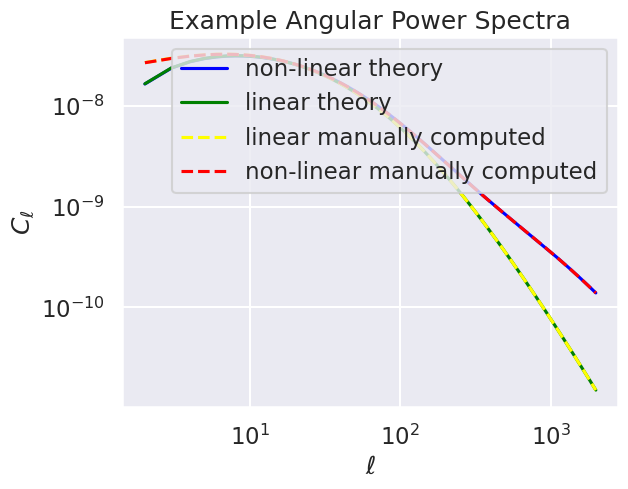

In [11]:
# Plots of C_ell

plt.plot(ell, data, "b", label = "non-linear theory")

plt.plot(ell, data_linear, "g", label = "linear theory")

plt.plot(ell, manualdata_linear, "yellow",linestyle="--", label = "linear manually computed")

plt.plot(ell,manualdata, "r",linestyle="--",  label = "non-linear manually computed")

#plt.plot(ell, data/manualdata)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.title("Example Angular Power Spectra")
plt.legend()

#plt.savefig('PCA_Cell_example.png')
plt.show()

#Note: low ell values differ because I'm using liber approximation (only works for high ell?)

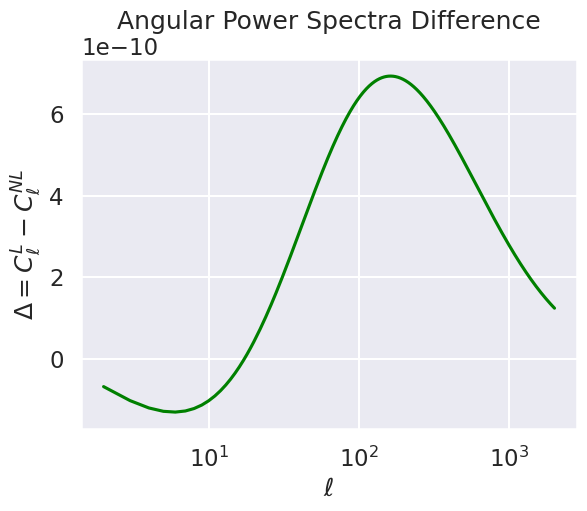

In [11]:
delta = data - data_linear
plt.plot(ell, delta, "g")

#plt.plot(ell, manualdata_linear, "yellow", label = "linear manually computed")

#plt.plot(ell,manualdata, "r", label = "non-linear manually computed")

#plt.plot(ell, data/manualdata)

plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\Delta = C^L_\ell - C^{NL}_\ell$')
plt.title("Angular Power Spectra Difference")
plt.show()

In [34]:
print("chi_max = ", ccl.comoving_radial_distance(cosmo,1/(1+1090.3)))

chi_max =  13946.40834035793


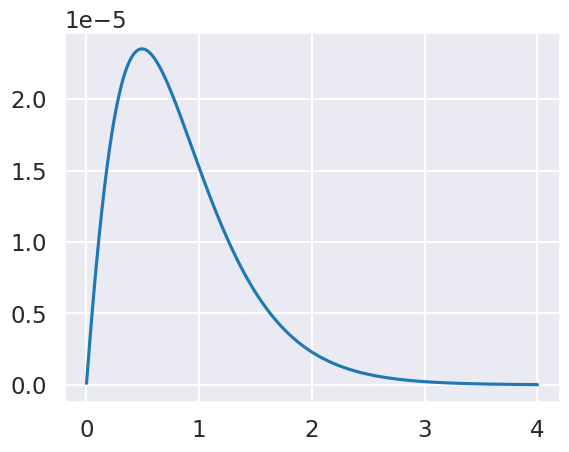

In [35]:
plt.plot(z,Wkappag(z, c, cosmo))

- (Not useful now) q are the radial weight functions:

Eq 2: $q^i_\kappa (\chi) = \frac{3H_0^2 \Omega_m \chi}{2a(\chi)} \int^{\chi_h}_\chi d\chi' \frac{\chi' - \chi}{\chi} n^i_\kappa (z(\chi')) \frac{dz}{d\chi'}$

Eq 3: $q^i_{\delta_g} (\chi) = b^i n^i_\delta (z(\chi)) \frac{dz}{d\chi}$



In [36]:
# bits of code I don't use now

# solves equation 2
# z is a single value not an array
def qkappaz(z, cosmo, c):
    #define useful quantities for integral
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)
    zh = 1/ccl.scale_factor_of_chi(cosmo, c/cosmo['H0']) - 1
    pz =  redshiftdist(z)
    
    #find integral
    x = np.linspace(0.01,zh,int(1e4)) #variable we integrate over
    chix = ccl.comoving_radial_distance(cosmo,1/(1 + x))
    integrand = pz*(chix - chiz)/chiz
    I = scipy.integrate.simps(integrand, x)
    qk = I*3*(cosmo['H0']**2)*Omega_m*chiz/(2*a*chiz)
    return qk

#solves equation 3
#z is a single value not an array
def qdelgz(z, cosmo, c, cosmo['H0'], Omega_m, bz):
    pz = redshiftdist(z)
    a = 1/(1 + z)
    qd = ccl.h_over_h0(cosmo,a)*pz*bz*cosmo['H0']/c
    return qd

SyntaxError: invalid syntax (<ipython-input-36-81515b5a641c>, line 22)